# Tutorial 2: more advanced optical systems and ray-tracing options.
In the previous tutorial we built a simple optical system consisting of a paraboloid. We then performed a ray-trace from the initial frame of rays to the paraboloid surface, and from the paraboloid we found the focus of the fram by calling the s.findRTfocus method. We did all of this using the tubular ray-trace frame input.

In this tutorial, we will introduce the Gaussian ray-trace frame. We will then create an optical setup that is slightly more advanced.

In [1]:
%matplotlib notebook

import numpy as np

from src.PyPO.System import System

s = System()

2023-04-06 18:18:12 - WARNING - System override set to True. 


After making an empty system, we are going to create our elements:

2023-04-06 18:18:21 - INFO - Added ellipsoid ellipsoid to system. 


<IPython.core.display.Javascript object>


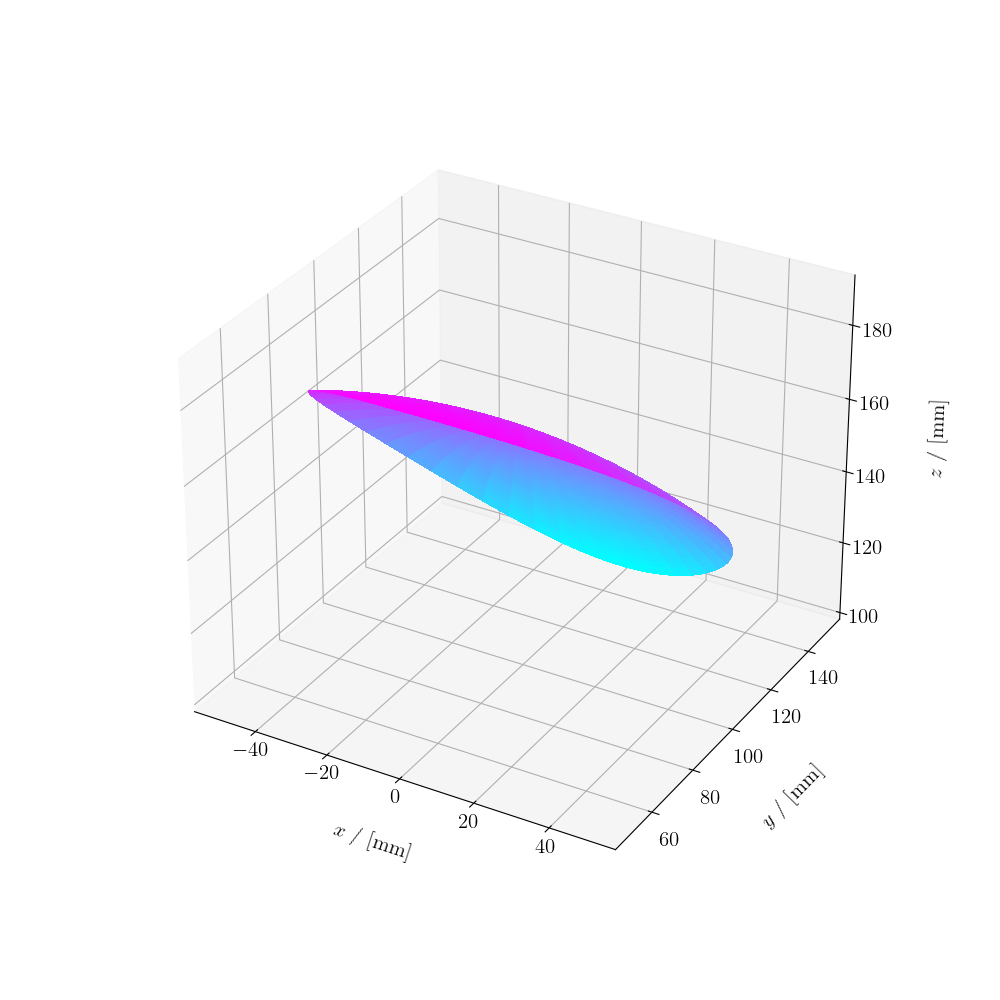

In [3]:
ellipse = {
            "name"      : "ellipsoid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, -100, 0]),
            "focus_2"   : np.array([0, 100, 0]),
            "ecc"       : 0.5,
            "lims_u"    : np.array([0, 50]),
            "lims_v"    : np.array([0, 360]),
            "gcenter"   : np.array([-100, 0]),
            "gridsize"  : np.array([801, 801])
            }

s.addEllipse(ellipse)
s.plotSystem()

2023-04-06 18:18:22 - INFO - Generating Gaussian ray-trace beam. 
2023-04-06 18:18:22 - INFO - ... Sampling ... 
2023-04-06 18:18:24 - INFO - Succesfully sampled 1000 rays: 1.5779564380645752 seconds. 
2023-04-06 18:18:24 - INFO - Added Gaussian frame start to system. 
2023-04-06 18:18:24 - INFO - Translated frame start by ('0.000e+00', '-1.000e+02', '0.000e+00') millimeters. 


<IPython.core.display.Javascript object>


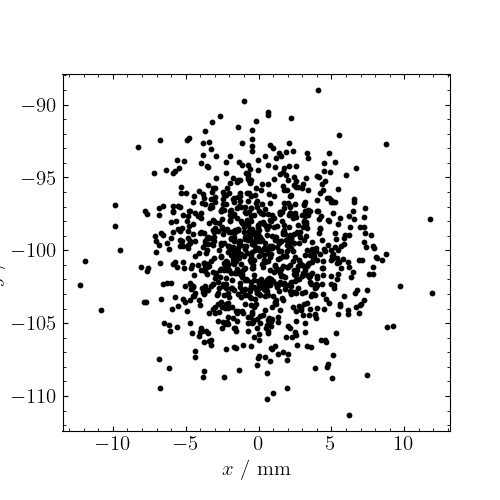

In [4]:
RTpar = {
        "name"      : "start",
        "nRays"     : 1000,
        "lam"       : 1.,
        "n"         : 1,
        "seed"      : 0,
        "x0"        : 5,
        "y0"        : 5
        }

s.createGRTFrame(RTpar)
s.translateGrids("start", np.array([0, -100, 0]), obj="frame")
s.plotRTframe("start")

2023-04-06 18:18:27 - INFO - *** Starting RT propagation *** 
2023-04-06 18:18:27 - INFO - Hardware: running 12 CPU threads. 
2023-04-06 18:18:27 - INFO - ... Calculating ... 
2023-04-06 18:18:27 - INFO - *** Finished: 0.007 seconds *** 


<IPython.core.display.Javascript object>


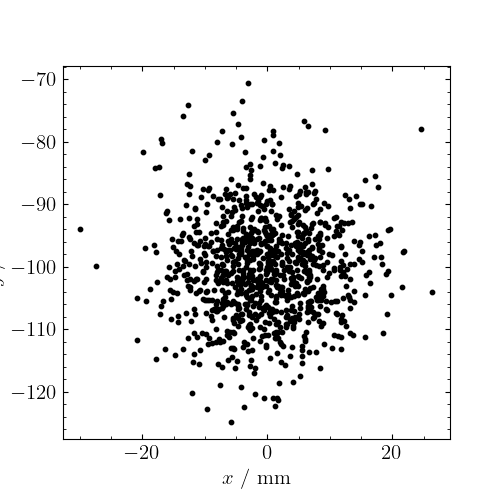

In [5]:
start_ell_RT = {
            "fr_in"     : "start",
            "t_name"    : "ellipsoid",
            "fr_out"    : "fr_ell",
            "device"    : "CPU",
            "tol"       : 1e-6
            }

s.runRayTracer(start_ell_RT)
s.plotRTframe("fr_ell", project='xy')

2023-04-06 18:18:29 - INFO - Focus: ('-2.037e-01', '1.008e+01', '1.404e+02'), RMS: 5.004e+00 


<IPython.core.display.Javascript object>


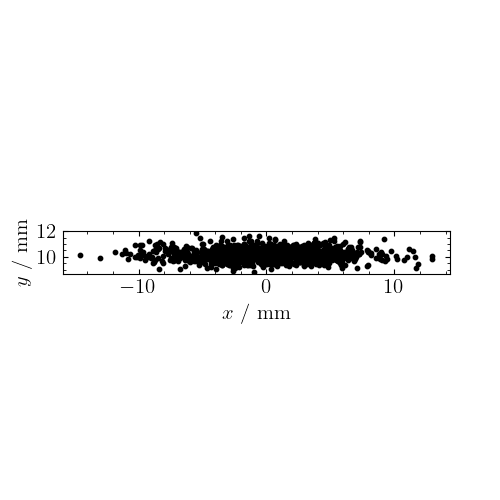

<IPython.core.display.Javascript object>


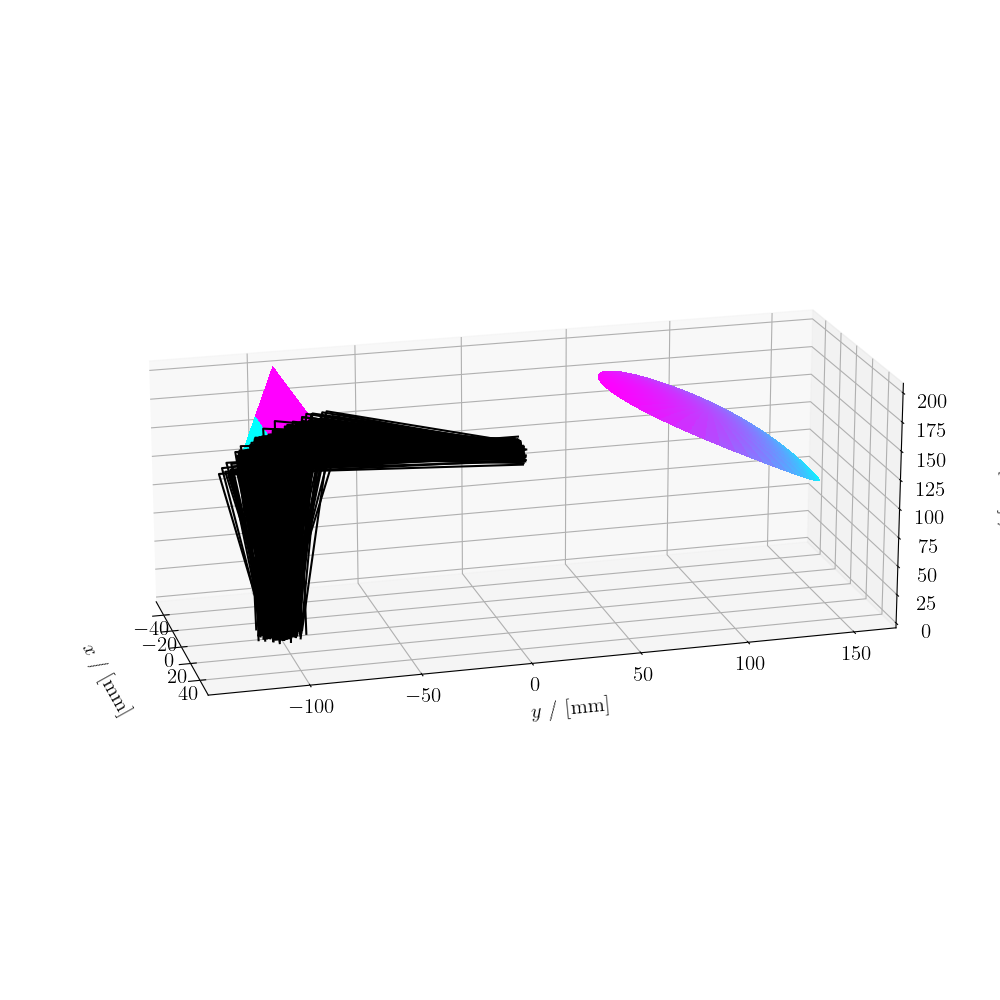

In [6]:
s.findRTfocus("fr_ell")

s.plotRTframe("focus_fr_ell")
s.plotSystem(RTframes=["start", "fr_ell", "focus_fr_ell"])